In [1]:
import pymc as pm
import dismod_mr as dm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import importlib

https://pypi.org/project/dismod-mr/
环境配置：安装conda 使用conda创建新的环境并安装pymc注意版本号，否则容易导致pymc安装失败，如出现安装错误，搜索报错内容更改合适的版本进行安装
conda create --name=dismod_mr python=3.6 pymc==2.3.8
启动环境：
conda activate dismod_mr
使用pip 安装dismod_mr
pip install dismod_mr

注意原始数据不能出现中文
导入csv数据，并进行数据准备
可以通过使用keep方法，对数据进行筛选与保留，进而单独对某地区、某一年的患病率进行分析
示例可以参考https://github.com/ihmeuw/dismod_mr/blob/389150ad70b4fe4cee167278402214ede80c1bb6/examples/pd_sim_data.ipynb
中 In[2]单元格的代码

In [2]:
# 导入数据，
df = pd.read_csv(r"input_data.csv")#csv文件地址

data = dict(age=df['age'],
            year=df['year'],
            )
data = pd.DataFrame(data)

# data['x_1'] = x_1[np.array(data.year-1995)]
# data['x_2'] = x_2[np.array(data.year-1995)]

data['value'] = df['p'] #从csv文件中导入所需的数据
data['data_type'] = 'p'

data['age_start'] = data.age
data['age_end'] = data.age+3

data['area'] = df['province'] #地区数据
data['sex'] = 'total'

data['standard_error'] = -99
data['upper_ci'] = np.nan
data['lower_ci'] = np.nan
data['effective_sample_size'] = 1.e8 # Arbitury numbers.

data.value = np.clip(data.value, 0, 1) # Move all data inside the interval [0, 1]

In [3]:
data

,age,year,value,data_type,age_start,age_end,area,sex,standard_error,upper_ci,lower_ci,effective_sample_size
0,3,2012,0.1422,p,3,6,ZheJiang,total,-99,NaN,NaN,100000000.0
1,3,2019,0.2048,p,3,6,JiangSu,total,-99,NaN,NaN,100000000.0
2,3,2020,0.2586,p,3,6,JiangSu,total,-99,NaN,NaN,100000000.0
3,3,2012,0.2505,p,3,6,ShanDong,total,-99,NaN,NaN,100000000.0
4,3,2019,0.0844,p,3,6,XiZang,total,-99,NaN,NaN,100000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
285,12,1995,0.7323,p,12,15,Overall,total,-99,NaN,NaN,100000000.0
286,12,2000,0.7704,p,12,15,Overall,total,-99,NaN,NaN,100000000.0
287,12,2005,0.7694,p,12,15,Overall,total,-99,NaN,NaN,100000000.0
288,12,2010,0.8161,p,12,15,Overall,total,-99,NaN,NaN,100000000.0


(2.0, 16.0)

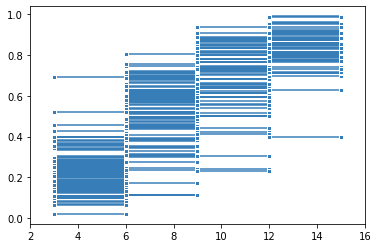

In [4]:
# 查看一下数据
dm_ = dm.data.ModelData()
dm_.input_data = data
dm_.plot('p')
plt.xlim((2,16))

In [5]:
# 建立模型
dm_.parameters['p'] = dict(parameter_age_mesh=[0,15], 
                           level_bounds={'lower': 0.0, 'upper': 1.0},
                           level_value={'age_after': 20, 'age_before': 0, 'value': 0.},
                           heterogeneity='Slightly',
                           fixed_effects={'x_sex': dict(dist='Constant', mu=0)})

In [6]:
#引入地区
for x in df.province:
    dm_.hierarchy.add_edge('all', x)

在拟合前可以在数据中引入先验协变量，如描述患病率随年龄、时间的变化的变量，还可以对这些变量进行预测。详情见
https://github.com/ihmeuw/dismod_mr/blob/389150ad70b4fe4cee167278402214ede80c1bb6/examples/predictive_covariates_for_time_trends.ipynb

In [7]:
#设置模型参数进行拟合
# dm_.set_knots('p', range(15))#可以设置拟合的节点数
dm_.vars = dm.model.asr(dm_, 'p', rate_type='neg_binom') #负二项分布模型
%time dm.fit.asr(dm_, 'p', iter=10000, burn=1000, thin=5) #iter:后验样本数，burn:后验样本burn-in数，thin:后验稀释倍数

## mare: mean absolute relative error

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.22
sampling from posterior

CPU times: user 11min 52s, sys: 144 ms, total: 11min 52s
Wall time: 11min 52s


(<pymc.NormalApproximation.MAP at 0x7ff2ea2ce9b0>,
 <pymc.MCMC.MCMC at 0x7ff2ea278898>)

(0.0, 15.0, -0.001, 1.038975)

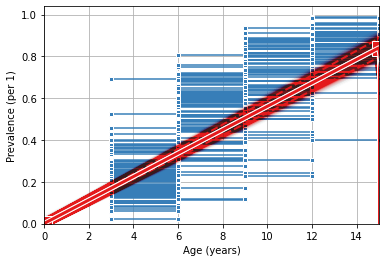

In [16]:
#绘制结果

dm_.plot('p')
plt.xlabel('Age (years)')
plt.ylabel('Prevalence (per 1)')
plt.grid()
# plt.legend(loc='upperleft')
plt.axis(ymin=-.001, xmin=0, xmax=15)

In [9]:
#设置输出模板才能进行预测
years = np.arange(1995,2023)
dm_.output_template = pd.DataFrame(dict(year=years))
dm_.output_template['sex'] = 'total'
dm_.output_template['pop'] = 100000  # 多地区时需要设置人口
dm_.output_template['area'] = 'all'
dm_.output_template.head()

,year,sex,pop,area
0,1995,total,100000,all
1,1996,total,100000,all
2,1997,total,100000,all
3,1998,total,100000,all
4,1999,total,100000,all


In [10]:
dm_.predict_for('p', 'all', 'total', 2000).mean()

0.06663775041070877

(0.0, 15.0, -0.001, 1.038975)

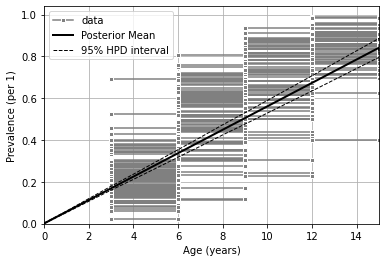

In [11]:
#预测患病率并绘图
dm.plot.data_bars(dm_.get_data('p'), color='grey', label='data')
pred = dm.model.predict_for(dm_, dm_.parameters['p'], 'all', 'total', 2005,
                                      'all', 'total', 2005, 1.,
                                      dm_.vars['p'], 0., 1.)    # 
hpd = pm.utils.hpd(pred, .05)
plt.plot(np.arange(101), pred.mean(axis=0), 'k-', linewidth=2, label='Posterior Mean')
plt.plot(np.arange(101), hpd[0,:], 'k--', linewidth=1, label='95% HPD interval')
plt.plot(np.arange(101), hpd[1,:], 'k--', linewidth=1)

plt.xlabel('Age (years)')
plt.ylabel('Prevalence (per 1)')
plt.grid()
plt.legend(loc='upper left')

plt.axis(ymin=-.001, xmin=0, xmax=15)

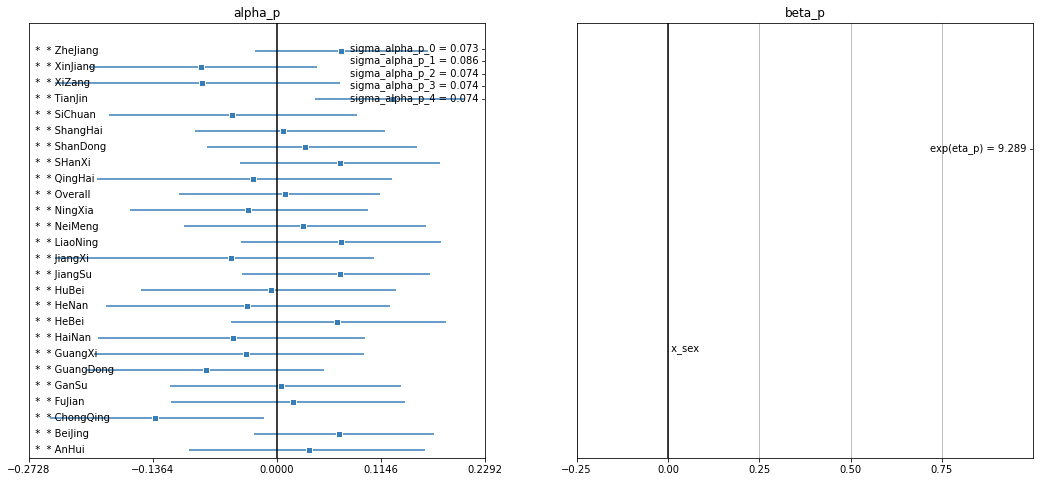

In [12]:
#绘制影响参数图
dm.plot.effects(dm_, 'p', figsize=(18,8))
plt.xticks(np.arange(-.25,1,.25))
plt.grid()

(-1.0, 18.0)

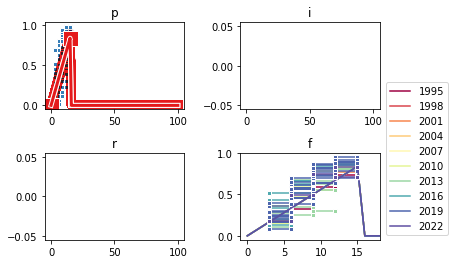

In [13]:
dm_.predict_for('p', 'all', 'total', 2_000).mean()
dm_.plot()
for y in range(1995,2023,3):
    color = plt.cm.Spectral((y-1995.)/25.)
    plt.plot(dm_.predict_for('p', 'all', 'total', y).mean(0), color=color, label=str(y))
    dm.plot.data_bars(dm_.input_data[dm_.input_data.year == y], color=color, label='')
plt.legend(loc=(1.05,.05))
plt.xlim((-1,18))


In [14]:
#可以将预测结果输出到csv文件中
pd.DataFrame(pred).to_csv('testout.csv')

(-0.027530000000000002, 1.03793, -1.0, 1.0)

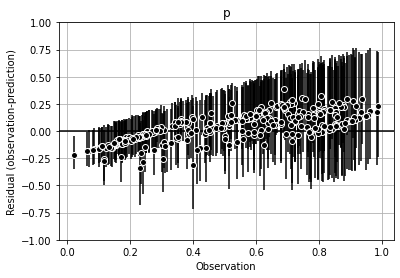

In [15]:
#绘制预测协变量残差
dm.plot.plot_one_ppc(dm_, 'p')
plt.axis(ymin=-1, ymax=1)

dismod-mr GitHub官方源码与示例：
https://github.com/ihmeuw/dismod_mr/tree/389150ad70b4fe4cee167278402214ede80c1bb6
其中包含了关于多级地区划分、专家先验的修改、收敛性检查，多级mcmc拟合以及关于如何进行协变量预测等内容。